In [18]:
# #######################################################################
# Imports
import logging
import os

import math
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
from numpy.fft import fft
import numpy as np
from scipy import fftpack
from scipy.signal import blackman
from pprint import pprint



# #######################################################################
# #######################       Parameters        #######################
# #######################################################################
DEBUG = 2
SKIP_BEG_SEC = 1        # remove what happens when the recording on the smartphone is started and put into pocket
SKIP_END_SEC = 1        # same, for the end, when removed from pocket
SKIP_CHANGE_SEC = 0.8     # same, between transitions
THRESHOLD = 1         # threshold to cut the data
LABELS = {"none": -1, "standing": 0,
          "walk_rested": 1, "walk_tired": 2, "walk_very_tired": 3}



In [8]:

# #######################################################################
# #######################         load CSV        #######################
# #######################################################################
def load_csv(file_name):
    # Get read of first line (sep=;) when reading the csv file
    data = pd.read_csv(file_name, sep=";", skiprows=1, index_col=None)
    data["labels"] = LABELS["none"]
    return data


In [9]:
# #######################################################################
# #######################       main function     #######################
# #######################################################################
def clean_data(data, tiredness_state):
    # Set the datetime as index
    data.date_time = pd.to_datetime(data["date_time"], format='%Y-%m-%d %H:%M:%S:%f')
    # data["index"] = range(data.shape[0])
    # data.set_index("index")
    # time_ms converted into seconds
    data.time_ms = data.time_ms / 1000
    # find total time, sampling frequency
    logging.debug(f'starts at {data["date_time"][0]}, ends at {data["date_time"].iloc[-1]}')
    total_time = (data["date_time"].iloc[-1] - data["date_time"][0])
    frequency = int(round(len(data) / total_time.seconds, 0))
    logging.debug(len(data))
    logging.debug(frequency)


    # #######################################################################
    # #####################       PRINT AND PLOT       ######################
    # #######################################################################
    logging.info("Printing section")
    # Print some stuff
    if DEBUG > 6:
        print(data.head())
        print(data.columns)
        print(data.dtypes)


    # Plotting
    if DEBUG > 7:
        columns = ["acc_x", "acc_y", "acc_z", "grav_x", "grav_y", "grav_z",
                   "lin_acc_x", "lin_acc_y", "lin_acc_z",
                   "gyro_x", "gyro_y", "gyro_z",
                   "mag_x", "mag_y", "mag_z", "sound_lvl", ]
        col_to_plot = ["acc_x", "acc_y", "acc_z", "gyro_x", "gyro_y", "gyro_z", "mag_x", "mag_y", "mag_z", ]
        plt.figure(f"{index}- ROW data")
        plt.plot(data.time_ms, data[col_to_plot])
        plt.legend(col_to_plot)
        plt.tight_layout()
        plt.show()



    # #######################################################################
    # #######################         FEATURES        #######################
    # #######################################################################
    logging.info("Feature engineering section")

    # window filter
    # add each difference on a 0.2 sec window
    # if that sum of noise is low, cut before, define it as standing state.
    # If DEBUG
    if DEBUG > 3:
        plt.figure(f"{index}- Smooth and acc variation")

    # Smoothing each acc axis
    axis = ('x', 'y', 'z')
    for xyz in axis:
        acc_smooth_xyz = f"acc_smooth_{xyz}"
        acc_derivative_xyz = f"acc_derivative_{xyz}"
        # Smooth acc on xyz axis
        data[acc_smooth_xyz] = data[f"acc_{xyz}"].rolling(round(0.2*frequency), win_type="hamming", center=True).sum()
        # compute derivative of each axis
        data[acc_derivative_xyz] = abs(data[acc_smooth_xyz].shift(1) - data[acc_smooth_xyz].shift(-1))
        if DEBUG > 5:
            plt.plot(data.time_ms, data[acc_smooth_xyz], label=acc_smooth_xyz)

    # sum of derivatives of each axis
    data["acc_sum"] = data["acc_derivative_x"] + data["acc_derivative_y"] + data["acc_derivative_z"]
    data["acc_sum_smoth"] = data["acc_sum"].rolling(round(0.8*frequency), win_type="hamming", center=True).sum() \
                            * 2 / round(0.8*frequency)


    # If DEBUG
    if DEBUG > 3:
        plt.plot(data.time_ms, data["acc_sum"], label="acc_sum")
        plt.plot(data.time_ms, data["acc_sum_smoth"], label="acc_sum_smoth")
        plt.tight_layout()
        plt.legend()
        plt.show()

    #
    # ##################################################################
    # skip beginning and end of files
    # Labels
    # ##################################################################
    data.drop(range(SKIP_BEG_SEC*frequency), inplace=True)
    data.index = range(data.shape[0])

    # Ensure that we found the resting state
    i0_set_rest = data[data["acc_sum_smoth"] < THRESHOLD].index[0]
    data.drop(data.index[range(i0_set_rest)], inplace=True)      # remove beginning with noise
    data.index = range(data.shape[0])
    i0_set_rest = 0
    # Label until the end of first rest
    i1_rest_walk = data.loc[data.index > i0_set_rest + SKIP_CHANGE_SEC*frequency, "acc_sum_smoth"][data["acc_sum_smoth"] > THRESHOLD].index[0]
    data.loc[data.index <= i1_rest_walk, "labels"] = LABELS["standing"]
    # Label until the end of first walking
    i2_walk_rest = data.loc[data.index > i1_rest_walk + SKIP_CHANGE_SEC*frequency, "acc_sum_smoth"][data["acc_sum_smoth"] < THRESHOLD].index[0]
    data.loc[(i1_rest_walk <= data.index) & (data.index < i2_walk_rest), "labels"] = LABELS[tiredness_state]
    # Label until the turn
    i3_rest_turn = data.loc[data.index > i2_walk_rest + SKIP_CHANGE_SEC*frequency, "acc_sum_smoth"][data["acc_sum_smoth"] > THRESHOLD].index[0]
    data.loc[(i2_walk_rest <= data.index) & (data.index < i3_rest_turn), "labels"] = LABELS["standing"]
    # Label until rest
    i4_turn_rest = data.loc[data.index > i3_rest_turn + SKIP_CHANGE_SEC*frequency, "acc_sum_smoth"][data["acc_sum_smoth"] < THRESHOLD].index[0]
    data.loc[(i3_rest_turn <= data.index) & (data.index < i4_turn_rest), "labels"] = LABELS["none"]
    # Label until 2nd walk
    i5_rest_walk = data.loc[data.index > i4_turn_rest + SKIP_CHANGE_SEC*frequency, "acc_sum_smoth"][data["acc_sum_smoth"] > THRESHOLD].index[0]
    data.loc[(i4_turn_rest <= data.index) & (data.index < i5_rest_walk), "labels"] = LABELS["standing"]
    # Label until 2nd rest
    i6_walk_rest = data.loc[data.index > i5_rest_walk + SKIP_CHANGE_SEC*frequency, "acc_sum_smoth"][data["acc_sum_smoth"] < THRESHOLD].index[0]
    data.loc[(i5_rest_walk <= data.index) & (data.index < i6_walk_rest), "labels"] = LABELS[tiredness_state]
    # Label until noise
    i7_rest_noise = data.loc[data.index > i6_walk_rest + SKIP_CHANGE_SEC*frequency, "acc_sum_smoth"][data["acc_sum_smoth"] > THRESHOLD].index[0] - 10
    data.loc[(i6_walk_rest <= data.index) & (data.index < i7_rest_noise), "labels"] = LABELS["standing"]
    # Drop end part
    data.drop(data.loc[(i7_rest_noise <= data.index)].index, inplace=True)

    # Collect indexes
    split_indexes = [i0_set_rest, i1_rest_walk, i2_walk_rest, i3_rest_turn, i4_turn_rest,
                     i5_rest_walk, i6_walk_rest, i7_rest_noise]

    if DEBUG > 1:
        print(split_indexes)
    if DEBUG > 5:
        print(data["labels"].sample(10))

    # Plots
    if DEBUG > 2:
        plt.figure(f"{index}- Sum of variation")
        plt.plot(data.time_ms, data["acc_sum"], label="acc_sum")
        plt.plot(data.time_ms, data["acc_sum_smoth"], label="acc_sum_smoth")
        plt.plot(data.time_ms, data["labels"], label="labels")
        plt.tight_layout()
        plt.legend()
        # plt.show()

    # Split each part
    split_frame = []
    for ind_low, ind_high in zip(split_indexes[:-1], split_indexes[1:]):
        split_frame.append({"label": data["labels"].iloc[ind_low],
                            "frame": data[(ind_low <= data.index) & (data.index < ind_high)]})
        if DEBUG > 6:
            print("ind low and high : ", ind_low, ind_high, data.shape)
            print(data["labels"].iloc[ind_low])

    return split_frame, frequency


In [10]:



# #######################################################################
# #######################          SETUP          #######################
# #######################################################################
# todo add label for walk speed  standing/slow/medium/fast

# Logging Settings
logging.basicConfig(level=logging.INFO)
logging.info("Setup section")

# Folder and Files
folder = "D:/Drive/Singapore/Courses/CS6206-HCI Human Computer Interaction/Project/Data"
os.chdir(folder)
files = [f for f in os.listdir(folder) if f.endswith(".csv")]
logging.info(f"found {len(files)} files in folder {folder}")

# Holders:
all_frames = []
frequencies = []


INFO:root:Setup section
INFO:root:found 18 files in folder D:/Drive/Singapore/Courses/CS6206-HCI Human Computer Interaction/Project/Data


In [11]:

# #######################################################################
# #######################          MAIN           #######################
# #######################################################################
# for index, file_name in enumerate([files[5], files[17]]):
for index, file_name in enumerate(files):

    if index not in (20,):
        # Fixing early experiments
        if index == 0:              THRESHOLD = 5.67
        elif index == 3:            THRESHOLD = 3.5
        elif index in range(5):     THRESHOLD = 4
        else:                       THRESHOLD = 2

        # if index in (0, 3): DEBUG = 4
        # else:  DEBUG = 0

        state = "none"
        if index in range(0, 6):      state = "walk_rested"
        elif index in range(6, 12):   state = "walk_tired"
        elif index in range(12, 18):  state = "walk_very_tired"

        print(f"\n *** File number {index} ***")
        frame = load_csv(file_name)
        print("data loaded")
        print(frame.shape)
        split_frame, frequency = clean_data(frame, state)
        print(frame.shape)
        print("data cleaned")

        all_frames.extend(split_frame)
        frequencies.append(frequency)

freq = sum(frequencies) / len(frequencies)

# whyyyyyy is plt. blocking...
plt.show()
plt.close("all")


INFO:root:Printing section



 *** File number 0 ***
data loaded
(4668, 19)


INFO:root:Feature engineering section


[0, 314, 1971, 2079, 2160, 2241, 3842, 4192]
(4192, 27)
data cleaned

 *** File number 1 ***
data loaded
(4905, 19)


INFO:root:Printing section
INFO:root:Feature engineering section


[0, 371, 2094, 2196, 2333, 2414, 3974, 4411]
(4411, 27)
data cleaned

 *** File number 2 ***
data loaded


INFO:root:Printing section


(4868, 19)


INFO:root:Feature engineering section


[0, 382, 2099, 2186, 2326, 2434, 4104, 4459]
(4459, 27)
data cleaned

 *** File number 3 ***
data loaded
(6189, 19)


INFO:root:Printing section
INFO:root:Feature engineering section


[0, 522, 2640, 2905, 3055, 3390, 5425, 5796]
(5796, 27)
data cleaned

 *** File number 4 ***
data loaded
(5278, 19)


INFO:root:Printing section
INFO:root:Feature engineering section


[0, 449, 2112, 2334, 2548, 2768, 4395, 4827]
(4827, 27)
data cleaned

 *** File number 5 ***
data loaded
(6223, 19)

INFO:root:Printing section


INFO:root:Feature engineering section


[0, 437, 2589, 2850, 3076, 3366, 5452, 5694]
(5694, 27)
data cleaned

 *** File number 6 ***
data loaded
(5594, 19)


INFO:root:Printing section
INFO:root:Feature engineering section


[0, 276, 2240, 2541, 2792, 2926, 4885, 5128]
(5128, 27)
data cleaned

 *** File number 7 ***
data loaded
(4999, 19)


INFO:root:Printing section
INFO:root:Feature engineering section


[0, 286, 2018, 2153, 2386, 2612, 4257, 4570]
(4570, 27)
data cleaned

 *** File number 8 ***
data loaded


INFO:root:Printing section


(6152, 19)


INFO:root:Feature engineering section


[0, 409, 2622, 2866, 3088, 3254, 5348, 5701]
(5701, 27)
data cleaned

 *** File number 9 ***
data loaded
(4955, 19)

INFO:root:Printing section


INFO:root:Feature engineering section


[0, 250, 1886, 2180, 2436, 2627, 4233, 4538]
(4538, 27)
data cleaned

 *** File number 10 ***
data loaded


INFO:root:Printing section


(6027, 19)


INFO:root:Feature engineering section


[0, 309, 2451, 2699, 2985, 3228, 5313, 5575]
(5575, 27)
data cleaned

 *** File number 11 ***
data loaded
(5999, 19)

INFO:root:Printing section


INFO:root:Feature engineering section


[0, 315, 2211, 2658, 2910, 3280, 5185, 5622]
(5622, 27)
data cleaned

 *** File number 12 ***
data loaded
(5368, 19)

INFO:root:Printing section


INFO:root:Feature engineering section


[0, 285, 2191, 2475, 2679, 2928, 4721, 4979]
(4979, 27)
data cleaned

 *** File number 13 ***
data loaded
(4791, 19)


INFO:root:Printing section
INFO:root:Feature engineering section


[0, 281, 1924, 2120, 2393, 2639, 4219, 4385]
(4385, 27)
data cleaned

 *** File number 14 ***
data loaded
(5941, 19)

INFO:root:Printing section


INFO:root:Feature engineering section


[0, 335, 2341, 2641, 2913, 3156, 5196, 5523]
(5523, 27)
data cleaned

 *** File number 15 ***
data loaded
(5000, 19)


INFO:root:Printing section
INFO:root:Feature engineering section


[0, 214, 1878, 2110, 2375, 2605, 4287, 4600]
(4600, 27)
data cleaned

 *** File number 16 ***
data loaded
(5966, 19)


INFO:root:Printing section
INFO:root:Feature engineering section


[0, 258, 2259, 2654, 2918, 3200, 5254, 5547]
(5547, 27)
data cleaned

 *** File number 17 ***
data loaded
(5198, 19)

INFO:root:Printing section


INFO:root:Feature engineering section


[0, 215, 2000, 2305, 2524, 2775, 4604, 4794]
(4794, 27)
data cleaned


In [12]:

print("\n")
print("Preprocessing done, continuing on single dataset extraction")
print("len(all_frames)", len(all_frames))
# pprint(all_frames)

# Setup
col_to_plot = {1: ["acc_x", "acc_y", "acc_z"],
               2: ["acc_derivative_x", "acc_derivative_y", "acc_derivative_z"],
               3: ["acc_sum", "acc_sum_smoth"],
               4: ["gyro_x", "gyro_y", "gyro_z"]}




Preprocessing done, continuing on single dataset extraction
len(all_frames) 126


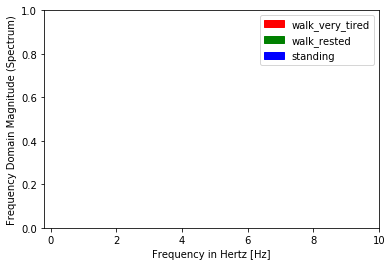

In [19]:

# Compute fft on all subsets
col_to_plot = ["acc_derivative_z",]

plt.figure(f"FFT comparison {col_to_plot}")
plt.xlabel('Frequency in Hertz [Hz]')
plt.ylabel('Frequency Domain Magnitude (Spectrum)')
plt.xlim([-0.2, 10])
red_patch = mpatches.Patch(color='red', label='walk_very_tired')
green_patch = mpatches.Patch(color='green', label='walk_rested')
blue_patch = mpatches.Patch(color='blue', label='standing')
plt.legend(handles=[red_patch, green_patch, blue_patch])

for index, dat in enumerate(all_frames):

    if dat["label"] != LABELS["none"] and dat["label"] != LABELS["walk_tired"]:

        state = list(LABELS.keys())[list(LABELS.values()).index(dat['label'])]
        dat["fft"] = {}

        for column in col_to_plot:

            signal = dat["frame"][column]

            f_s = freq
            X = fftpack.fft(signal)
            freqs = fftpack.fftfreq(len(signal)) * f_s

plt.show()